## County voters


See the 'precinct-visualization' for more information. This extends to the county level.

In [1]:
from arcgis import downloader, utils
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import pandas as pd

matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
!test -f data/Precincts.shp || ( wget https://s3.amazonaws.com/dl.ncsbe.gov/PrecinctMaps/SBE_PRECINCTS_20161004.zip && unzip SBE_PRECINCTS_20161004.zip )

In [3]:
!test -f data/durham.shp || ogr2ogr -sql "select * from Precincts where COUNTY_NAM='DURHAM'" -t_srs EPSG:4326 data/durham.shp data/Precincts.shp

In [4]:
!ogr2ogr -f geojson data/durham.geojson data/durham.shp

ERROR 6: The GeoJSON driver does not overwrite existing files.
geojson driver failed to create data/durham.geojson


In [5]:
durham = gpd.GeoDataFrame.from_file("data/durham.shp")
bounds = durham.bounds

highways_url_template = "http://gisweb2.durhamnc.gov/arcgis/rest/services/PublicWorks/PublicWorks/MapServer/54/query?f=json&geometry={},{},{},{}&returnGeometry=true&outFields=*&outSR=4326&inSR=4326"
highways = downloader.get_shp(highways_url_template, 'data/highways-{}'.format('durham'), bounds)

lots = {}
for precinct in durham['PREC_ID'].unique():
    bounds = durham[durham.PREC_ID==precinct].bounds
    all_lots_url_template = "http://gisweb2.durhamnc.gov/arcgis/rest/services/PublicWorks/PublicWorks/MapServer/89/query?f=json&geometry={},{},{},{}&returnGeometry=true&outFields=*&outSR=4326&inSR=4326"
    lots[precinct] = downloader.get_shp(all_lots_url_template, 'data/all_lots-{}'.format(precinct), bounds)

In [6]:
print('Properties from arcgis boundary: {}'.format(len(lots)))
all_lots = pd.concat(lots.values())
print(len(all_lots))
# all_lots.set_index('SITE_ADDRE')
# all_lots = all_lots[~all_lots.index.duplicated(keep='first')]
# print(len(all_lots))

Properties from arcgis boundary: 57
225106


In [7]:
voters = pd.read_csv('data/ncvoter32.txt', sep=None)

/Users/danesummers/.virtual_env/nc_election/lib/python3.5/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [15]:
voters_in_county = voters[voters.county_desc=="DURHAM"]
voters_in_county = voters_in_county[~voters_in_county.voter_status_desc.isin(['DENIED', 'REMOVED'])]
voters_in_county.voter_status_desc.value_counts()

ACTIVE       177446
INACTIVE      39690
TEMPORARY       153
Name: voter_status_desc, dtype: int64

RES                          169870
VAC RES                       29539
COM                            9665
VACANT COMMUNITY SERVICE       3055
CMNTY SVC                      2764
VACANT COMMERCIAL              2462
VACANT LAND (UNDIFF)           1337
PRESENT-USE                    1293
VACANT INDUSTRIAL               750
VAC AG                          719
WILD                            587
AG                              509
PUBL SVC                        453
VAC COM                         405
COMMUNITY SVCS (UNDIFF)         328
IND                             322
REC                             296
VACANT PUBLIC UTILITY           219
CMNTY SVS                       123
VAC PRV UTL                      91
VAC COMM SVC                     85
C0M                              63
VAC                              47
PUBLIC SERVICE (UNDIFF)          46
WILD-FRST-CONS LD(UNDIFF)        40
VACANT PRIVATE UTILITY           22
LR CONVEYANCE                    10
VAC PU                      

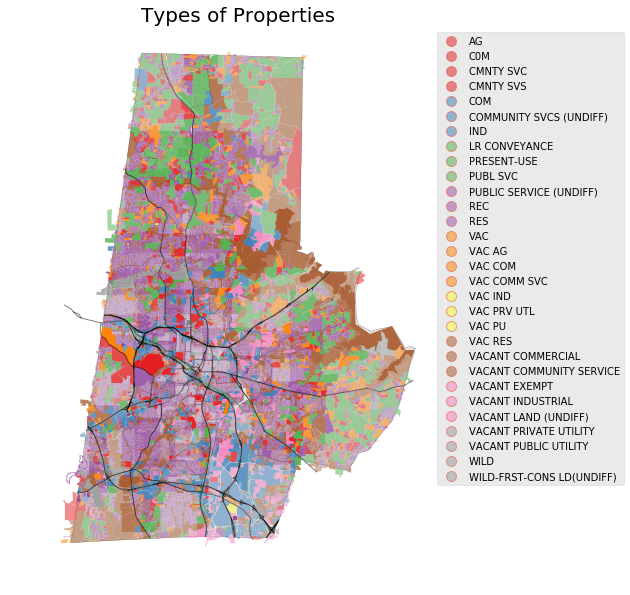

In [9]:
all_lots['LANDUSE_CODE'] = all_lots['LANDUSE_DE'].str.replace(r'/.*$','')

fig, ax = plt.subplots(1, figsize=(7,10))
durham.plot(ax=ax, color='black', alpha=0.1, linewidth=0.2)
highways.plot(ax=ax, color='black', edgecolor='black', alpha=0.5)

all_lots.plot(ax=ax, column='LANDUSE_CODE', linewidth=0, legend=True)
ax.axis('off')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 1., 0.5, 0.0))
plt.title('Types of Properties', fontsize=20)

all_lots['LANDUSE_CODE'].value_counts()

In [10]:
# so now that I have a shapefile of residential addresses, lets make files of addresses
# with no voters:

# remove apartment numbers from addresses, to match up more addresses.
# TODO it might be possible to determine how many addresses have multiple tenants and use this apartment
# number to determine which apartments have no registered addresses:
utils.create_address_fields(voters_in_county, 'res_street_address')
utils.create_address_fields(all_lots, 'SITE_ADDRE')

voters_in_county['clean_number_address'] = voters_in_county['clean_street_number'] + ' ' + voters_in_county['clean_street_name']
all_lots['clean_number_address'] = all_lots['clean_street_number'] + ' ' + all_lots['clean_street_name']

matched_regs = all_lots.query('clean_number_address in @voters_in_county.clean_number_address')
non_matched_props = all_lots.query('clean_number_address not in @voters_in_county.clean_number_address')
non_matched_regs = voters_in_county.query('clean_number_address not in @all_lots.clean_number_address')

# filter out properties that are definitely NOT residential:
non_matched_props = non_matched_props[~non_matched_props.LANDUSE_DE.str.startswith('AG')]
non_matched_props = non_matched_props[~non_matched_props.LANDUSE_DE.str.startswith('COM')]
non_matched_props = non_matched_props[~non_matched_props.LANDUSE_DE.str.startswith('C0M')]
non_matched_props = non_matched_props[~non_matched_props.LANDUSE_DE.str.startswith('CMNTY SVC')]
non_matched_props = non_matched_props[~non_matched_props.LANDUSE_DE.str.startswith('CMNTY SVS')]
non_matched_props = non_matched_props[~non_matched_props.LANDUSE_DE.str.startswith('IND')]
non_matched_props = non_matched_props[~non_matched_props.LANDUSE_DE.str.startswith('LR CONVEYANCE')]
non_matched_props = non_matched_props[~non_matched_props.LANDUSE_DE.str.startswith('PRESENT-USE')]
non_matched_props = non_matched_props[~non_matched_props.LANDUSE_DE.str.startswith('PUBL SVC')]
non_matched_props = non_matched_props[~non_matched_props.LANDUSE_DE.str.startswith('PUBLIC')]
non_matched_props = non_matched_props[~non_matched_props.LANDUSE_DE.str.startswith('REC')]
non_matched_props = non_matched_props[~non_matched_props.LANDUSE_DE.str.startswith('VAC')]
non_matched_props = non_matched_props[~non_matched_props.LANDUSE_DE.str.startswith('WILD')]

## Joining Parcels to Voter Registrations

Joining properties to voter registration is not exact. I joined the data sets by their address. Since property parcels don't hove apartment numbers, I created a new field by stripping out the apartment number before joining. What we're left with are three data sets:

 * Joined data: a match between a voter registration and and address. Of course there can be as many of these as there are registered voters at the address.
 * Properties without voters: these could be commercial properties, park properties, or unregistered voters. After joining all property addresses to voter logs, I removed the commercial/park/city properties as these are not likely to have voters living at the address.
 * Voter registrations without an address match: These really should have a match - the focus going forward should be in reducing this number as much as possible! I've found these can be voters that live in apartments (I've found one instance where the property address of an apartment complex was different than the actual apartment addresses - I've found another city run API that returns all apartments #s for an address...this might be one way of getting at these voters). It may be that some addresses are considered to be in the precinct, even if they don't fall within the precinct boundary. Further analysis is needed.

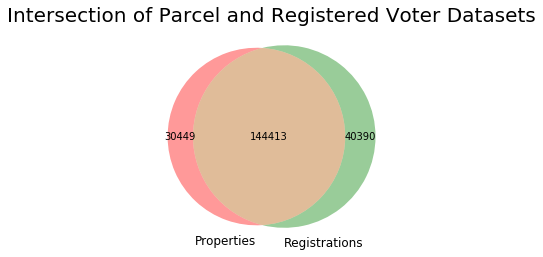

In [11]:
venn2(subsets = (len(non_matched_props), len(non_matched_regs), len(matched_regs)), set_labels=('Properties', 'Registrations'))
plt.title('Intersection of Parcel and Registered Voter Datasets', fontsize=20)

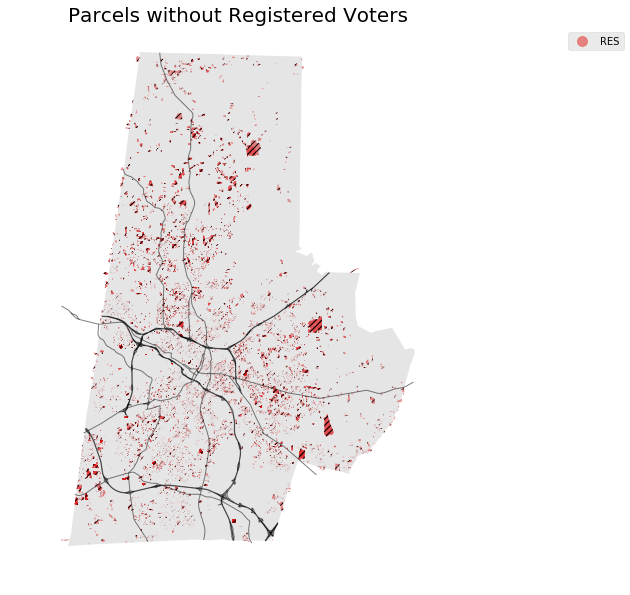

In [12]:
fig, ax = plt.subplots(1, figsize=(7,10))
durham.plot(ax=ax, color='black', alpha=0.1, linewidth=0)
highways.plot(ax=ax, color='black', edgecolor='black', alpha=0.5)
non_matched_props.plot(ax=ax, column='LANDUSE_CODE', edgecolor='none', legend=True, hatch='////')
ax.axis('off')
leg = ax.get_legend()
leg.set_bbox_to_anchor((1., 1., 0.5, 0.0))
plt.title('Parcels without Registered Voters', fontsize=20)

In [13]:
non_matched_regs.columns
non_matched_regs['voter_status_desc'].value_counts()
# non_matched_regs = non_matched_regs.fillna('missing')
# non_matched_regs[non_matched_regs['mail_addr1'].str.match(r'^$')]

ACTIVE       30180
INACTIVE     10175
TEMPORARY       35
Name: voter_status_desc, dtype: int64

/Users/danesummers/.virtual_env/nc_election/lib/python3.5/site-packages/geopandas/plotting.py:414: SyntaxWarning: Only specify one of 'column' or 'color'. Using 'color'.
  SyntaxWarning)


Voter breakdown:


DEM    163018
UNA     86443
REP     42057
LIB      1215
Name: party_cd, dtype: int64

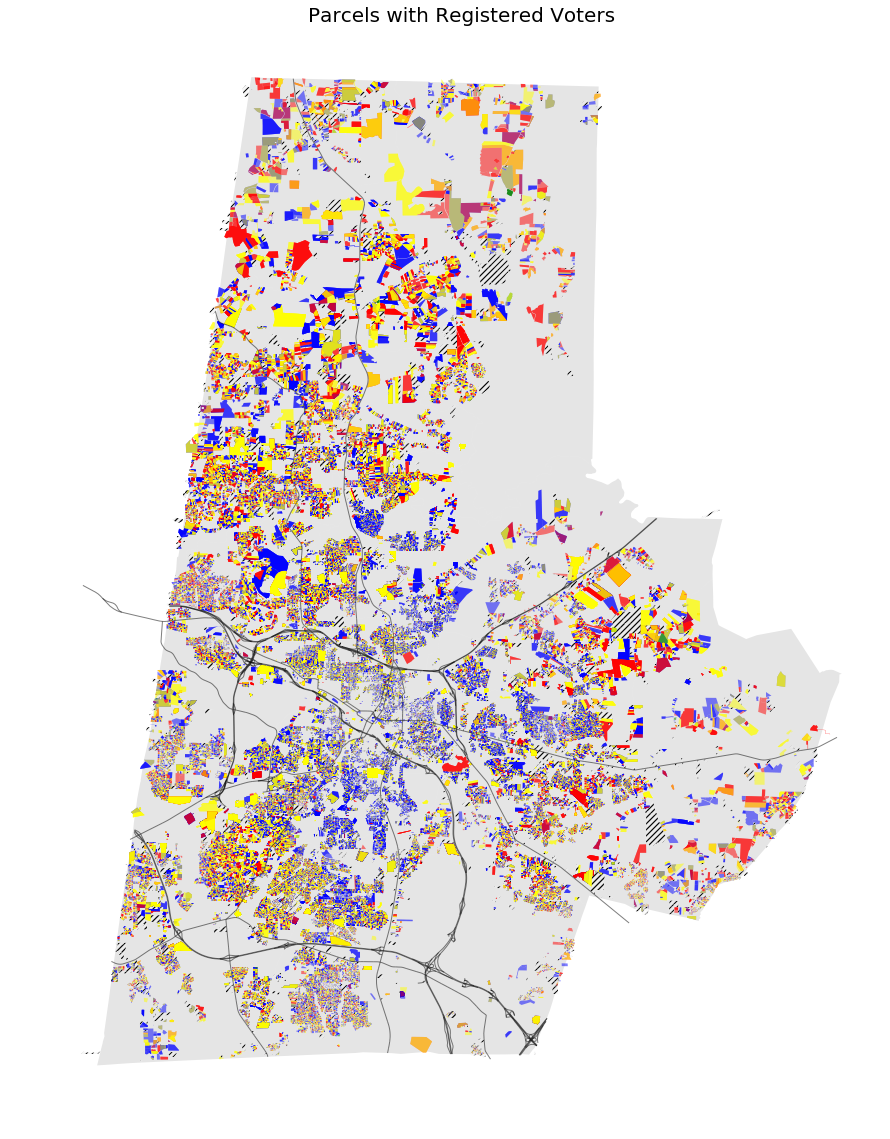

In [14]:
# and by party. Note that some places are super blue/red (all blue/red voters in the house).
# Purple for mixed houses, etc.

voters_pd = all_lots.merge(voters_in_county,left_on='SITE_ADDRE',right_on='mail_addr1')

colors = {
    'DEM': 'blue',
    'LIB': 'green',
    'REP': 'red',
    'UNA': 'yellow'
}

fig, ax = plt.subplots(1, figsize=(15,20))
ax.axis('off')

# plot the boundary file and the properties without voters:
durham.plot(ax=ax, color='black', alpha=0.1, linewidth=0)
highways.plot(ax=ax, color='black', edgecolor='black', alpha=0.5)
non_matched_props.plot(ax=ax, color='#eeeeee', edgecolor='none', hatch='////')

# then plot each voter:
for k,v in colors.items():
    voters_pd[voters_pd.party_cd==k].plot(
        ax=ax, column='party_cd', linewidth=0, alpha=0.5, color=v
    )

plt.title('Parcels with Registered Voters', fontsize=20)
    
print("Voter breakdown:")
voters_pd['party_cd'].value_counts()